In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hdbscan
import seaborn as sns
import scipy.optimize as opt

In [2]:
# Calculate coordinates from lattice vectors a, b and indices
def calc_coords(a, b, indices):
    coefficients = np.array((a, b))
    return np.dot(indices, coefficients)

# Helper function to generate grids
def peak_grid(zero, v1, v2, xes, yes, delta, exclude = ()):
    zero = np.array(zero)
    v1 = np.array(v1)
    v2 = np.array(v2)
    exclude = np.array(exclude)
    i, j = np.meshgrid(xes, yes)
    indices = np.concatenate(np.array((i, j)).T)
    select = np.ones_like(indices[:,0], dtype=np.bool)
    for e in exclude:
        # Only include values where at least one is different from the exclude list
        select *= (np.not_equal(indices[:,0], e[0]) + np.not_equal(indices[:,1], e[1]))
    indices = indices[select]
    d = np.random.randn(*indices.shape) * delta
    coords = zero + d + calc_coords(v1, v2, indices)
    return coords

# Helper function to filter grids
def ring_filter(coords, center, r1, r2):
    distances = np.linalg.norm(center - coords, axis=1)
    select = (distances >= r1) * (distances < r2)
    return(coords[select])

# accept list of polar vectors, return list of cartesian vectors
def make_cartesian(polar):
    xes = np.cos(polar[:,1]) * polar[:, 0]
    yes = np.sin(polar[:,1]) * polar[:, 0]
    return np.array((xes, yes)).T
    
# accept list of cartesian vectors, return list of polar vectors
def make_polar(cartesian):
    ds = np.linalg.norm(cartesian, axis=1)
    alphas = np.arctan2(cartesian[:,1], cartesian[:,0])
    return np.array((ds, alphas)).T

# Test case for correct math
v = np.array([[2, 3], [7, 9]])
assert(np.allclose(v, make_cartesian(make_polar(v))))

In [3]:
# Make a bunch of grids with different characteristics
coords_1 = ring_filter(
    peak_grid(
        (0,0),
        (0.7, 0.39), 
        (0.7, -0.39), 
        np.arange(-5, 5), 
        np.arange(-5, 5), 
        0.01),
    (0,0), 
    0, 
    3
)

coords_2 = ring_filter(
    ring_filter(
        peak_grid(
            (0,0),
            (0.5, 0.4), 
            (0.3, -0.8), 
            np.arange(-5, 5), 
            np.arange(-5, 5), 
            0.01,
            [(0,0)]
        ),
        (3,3), 
        3, 
        5
    ),
    (0,0),
    0,
    2.5 
)

coords_3 = np.array([
    [0.34, 2.256],
    [1.76, -1.3]
])

coords_4 = ring_filter(
    ring_filter(
        peak_grid(
            (0,0),
            (0.6, 0.43), 
            (0.41, -0.89), 
            np.arange(-5, 5), 
            np.arange(-5, 5), 
            0.01,
            [(0,0)]
        ),
        (-3,3), 
        3, 
        5
    ),
    (0,0),
    0,
    2.5 
)

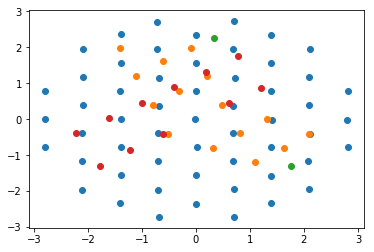

In [4]:
fig, axes = plt.subplots()
axes.scatter(coords_1[:,0], coords_1[:,1])
axes.scatter(coords_2[:,0], coords_2[:,1])
axes.scatter(coords_3[:,0], coords_3[:,1])
axes.scatter(coords_4[:,0], coords_4[:,1])

In [5]:
coords = np.concatenate((coords_1, coords_2, coords_3, coords_4))
#coords = coords_1

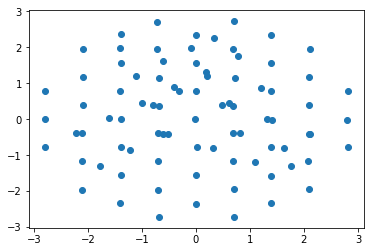

In [6]:
fig, axes = plt.subplots()
axes.scatter(coords[:,0], coords[:,1])

In [7]:
# Limits for connecting vector length to be considered a base vector candidate
limits = {
    'min_delta': 0.1,
    'max_delta': 3
}

# The size filter only retains vectors with absolute values between min_delta
# and max_delta to avoid calculating for unwanted higher order or random smaller vectors
def make_polar_vectors(coords, min_delta=0, max_delta=np.float('inf')):
    # sort by x coordinate so that we have always positive x difference vectors
    sort_indices = np.argsort(coords[:,0])
    coords = coords[sort_indices]
    i, j = np.mgrid[0:len(coords), 0:len(coords)]
    selector = j > i
    deltas = coords[j[selector]] - coords[i[selector]]
    polar = make_polar(deltas)
    
    size_filter = (polar[:,0] > min_delta) * (polar[:,0] < max_delta)
    return polar[size_filter]

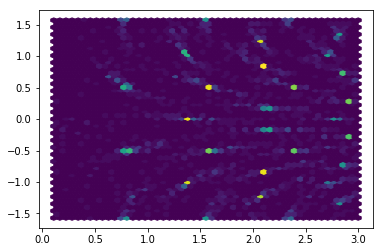

In [8]:
vectors = make_polar_vectors(coords, **limits)
fig, axes = plt.subplots()
axes.hexbin(vectors.T[0], vectors.T[1], gridsize=50)

[False False False ... False  True False]


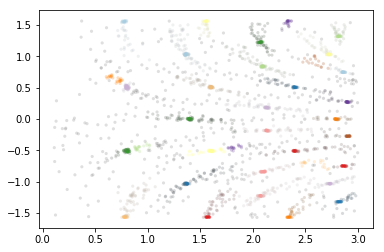

In [9]:
vectors = make_polar_vectors(coords, **limits)

# These settings should be fairly tight, throwing away
# anything that is fluffy or poorly populated
def make_config(points):
    return {
        'min_cluster_size': max(len(points)//5, 2),
        'min_samples': max(len(points)//20, 2)
    }

params = make_config(coords)
clusterer = hdbscan.HDBSCAN(**params).fit(vectors)
print(clusterer.labels_ == 0)
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*vectors.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [10]:
# Use clustering to find potential candidates for lattice vectors.
# We rely on the clusterer and its settings to give us tight and well-populated clusters.
# Then we calculate mean and standard deviation for each cluster
# and then filter again for tightness.
# In the end we return the shortest matches.
def candidates(points, min_delta=0, max_delta=np.float('inf')):
    clusterer = hdbscan.HDBSCAN(**make_config(points))
    vectors = make_polar_vectors(points, min_delta=min_delta, max_delta=max_delta)
    clusterer.fit(vectors)
    labels = clusterer.labels_
    cand = []
    for cluster in range(max(labels) + 1):
        selector = labels == cluster
        v = vectors[selector]
        weights = clusterer.probabilities_[selector]
        std = v.std(axis=0)
        fom = np.linalg.norm(std)
        # FIXME magic number, make user parameter
        if fom > 0.3:
            # print("too fuzzy")
            continue
        mean = np.average(v, axis=0, weights=weights)
        cand.append({
                'cluster': cluster, 
                 'mean': mean, 
                 'count': np.count_nonzero(selector), 
                 'mask': selector
        })
    # return the shortest candidate vectors
    # FIXME magic number 5
    return sorted(cand, key=lambda d: d['mean'][0])[:5]    

In [11]:
# Find indices to express each point as sum of lattice vectors from zero point
# This could solve for arbitrarily many points, i.e. frame stacks instead of frame by frame
# With that the algorithm could actually match entire frame collections at once
def vector_solver(points, zero, a, b):
    coefficients = np.array((a, b)).T
    target = points - zero
    result = np.linalg.solve(coefficients, target.T).T
    return result

In [12]:
# In the real world would be the brightest peak or user input
zero = np.array((0, 0))

# Find points that can be generated from the lattice vectors with near integer indices
# Return matched points, corresponding indices, and remainder
def match_all(points, zero, a, b):
    indices = vector_solver(points, zero, a, b)
    rounded = np.around(indices)
    errors = np.linalg.norm(np.absolute(indices - rounded), axis=1)
    # FIXME magic number, make user parameter
    matched_selector = (errors < 0.1)
    matched = points[matched_selector]
    matched_indices = rounded[matched_selector].astype(np.int)
    remainder = points[np.invert(matched_selector)]
    return (matched, matched_indices, remainder)
  
# Find the pair of lattice vectors that generates most matches
# Return vectors and additional info about the match
def find_vector_match(points, min_delta, max_delta):
    # Get some candidates
    cand = candidates(points, min_delta=min_delta, max_delta=max_delta)
    match_matrix = {}
    # we test all pairs of candidate vectors
    # and populate match_matrix
    for i in range(len(cand)):
        for j in range(i+1, len(cand)):
            a = cand[i]['mean']
            b = cand[j]['mean']
            angle_difference = abs(a[1] - b[1])
            if angle_difference < np.pi/5 or angle_difference > np.pi*4/5:
                # too collinear, not good lattice vectors
                continue
            a, b = make_cartesian(np.array([a, b]))
            match_matrix[(i, j)] = match_all(points, zero, a, b)
    if match_matrix:
        # we select the entry with highest number of matches
        candidate_index, match = sorted(match_matrix.items(), key=lambda d: len(d[1][1]), reverse=True)[0]
        polar_a = cand[candidate_index[0]]['mean']
        polar_b = cand[candidate_index[1]]['mean']
        a, b = make_cartesian(np.array([polar_a, polar_b]))
        return (a, b, match)
    else:
        # FIXME use proper exception subclass
        raise Exception
        
def optimize(a, b, matched, matched_indices):    
    # The minimizer expects a flat array, so we disassemble the vectors
    a1, a2 = a
    b1, b2 = b

    def error_function(vec):
        # ... and reassemble them here
        a1, a2, b1, b2 = vec
        a = np.array((a1, a2))
        b = np.array((b1, b2))
        errors = matched - calc_coords(a, b, matched_indices)
        error = (errors**2).sum()
        return error
    
    x0 = np.array((a1, a2, b1, b2))
    res = opt.minimize(error_function, x0=x0)
    
    a1, a2, b1, b2 = res.x
    new_a = np.array((a1, a2))
    new_b = np.array((b1, b2))

    return np.array((new_a, new_b))

# In the real world, this would distinguish more between finding good candidates
# from sum frames or region of interest
# and then match to individual frames
# The remainder of all frames could be thrown together for an additional round of matching
# to find faint and sparse peaks.
def find_all_matches(points, min_delta=0, max_delta=np.float('inf')):
    matches = []
    while True:
        # FIXME use proper exception subclass
        try:
            a, b, (matched, matched_indices, remainder) = find_vector_match(points, min_delta, max_delta)
        except Exception as e:
            break
        new_a, new_b = optimize(a, b, matched, matched_indices)
        # Re-match with refined vectors
        (matched, matched_indices, remainder) = match_all(points, zero, new_a, new_b)
        matches.append((new_a, new_b, matched, matched_indices))
        # clustering with less than four points makes no sense
        # since that spans a grid by itself
        if len(remainder) < 4:
            break
        # no endless loops
        if len(remainder) == len(points):
            break
        points = remainder
    return (matches, remainder)


In [13]:
%timeit (matches, remainder) = find_all_matches(coords, **limits)

134 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
# %prun (matches, remainder) = find_all_matches(coords, **limits)
(matches, remainder) = find_all_matches(coords, **limits)

Lattices:
[0.69886865 0.38993927] [ 0.69930946 -0.3907433 ]
[0.50554516 0.40207699] [ 0.29997145 -0.79722722]
[0.60001358 0.43047166] [ 0.40915399 -0.8947091 ]
Remainder:
 [[ 0.34   2.256]
 [ 1.76  -1.3  ]]


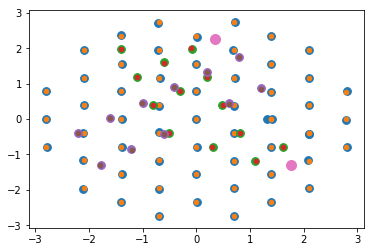

In [15]:
print("Lattices:")
for (a, b, matched, matched_indices) in matches:
    print(a, b)
    plt.scatter(matched.T[0], matched.T[1], s=60)
    calc = calc_coords(a, b, matched_indices)
    plt.scatter(calc.T[0], calc.T[1], s=20)
if len(remainder) > 0:
    plt.scatter(remainder.T[0], remainder.T[1], s=100)
    print("Remainder:\n", remainder)
else:
    print("No remainder")